In [1]:
from fastai.vision import *
from fastai import *
import pandas as pd
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from sklearn.metrics import *
import resnet
import xmltodict
from fastai.text import *
from fastai.tabular import *
from fastai.callbacks import *
import gc

In [2]:
path = '/media/axel/ssd/despegar/'

In [3]:
#data.show_batch(rows=3, figsize=(5,5))

In [4]:
dir_ = pathlib.Path(path+'train_annotations_pascal/')
file_objects_map = {}
i = 0
all_tags = []

for pth in dir_.iterdir():
    
    with open(pth) as fd:
        doc = xmltodict.parse(fd.read())
        try:
            l = []
            for dic in doc['annotation']['object']:
                l.append(dic['name'].replace(' ', ''))
            l = list(set(l))
            l.sort()
            all_tags = all_tags + l
            
            file_objects_map[i] = [pth.stem, ''.join(str(e) + ' ' for e in l)[:-1]]
        except:
            continue
            
    i += 1

all_tags = set(all_tags)

KeyboardInterrupt: 

In [ ]:
# pd.DataFrame.from_dict(file_objects_map, orient='index', columns=['image_name', 'tags']).to_csv(path+'train_2.csv', index=False)

In [ ]:
df2 = pd.read_csv(path+'train_2.csv')
df2 = pd.DataFrame(df2['tags'])
df2['label'] = df['label']

In [ ]:
np.random.seed(42)
tfms = get_transforms(do_flip=True, max_rotate=20.,)
src = (ImageList.from_csv(path, 'train_2.csv', folder='train', suffix='')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))
data = (src.transform(tfms, size=256)
        .databunch(bs=10).normalize(imagenet_stats))

In [ ]:
#data.show_batch(rows=3, figsize=(12,9))

In [19]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, models.resnet50, metrics=[acc_02, f_score])

In [20]:
# learn.lr_find()
# learn.recorder.plot()

In [21]:
learn.fit_one_cycle(1, 0.05)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.028512,0.022667,0.993106,0.414397,01:02


In [12]:
learn.unfreeze()

In [65]:
data.add_test(ImageList.from_folder(path+'test'))
data.test_ds.x.items.sort()

In [16]:
preds = learn.get_preds(DatasetType.Test)

In [27]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds[0]]

In [200]:
labelled_preds[5]

' cabinet ceiling ceilinglamp faucet floor wall window'

In [25]:
data_text = TextClasDataBunch.from_df('./', train_df=df3[:3000], valid_df=df3[3000:], text_cols=0, label_cols=1, bs=256)

In [30]:
df3 = pd.DataFrame(0, index=np.arange(len(df2)), columns=all_tags,)

In [31]:
for index, row in df2.iterrows():
    tags = row.tags.split()
    
    for tag in tags:
        df3.iloc[index][tag] = 1

#df3['label'] = df2['label']

In [32]:
procs = [FillMissing, Categorify, Normalize]

for col in df3.columns:
    df3[col] = df3[col].astype('category')

In [28]:
data = (TabularList.from_df(df3, path=path, cat_names=all_tags, cont_names=[],)
                           .split_by_idx(list(range(0,2000)))
                           .label_from_df(cols='label')
                           .databunch(bs=120))
                           
#data = TabularDataBunch.from_df(path, df3[:2000], df3[2000:], 'label', procs=procs, cat_names=all_tags)

In [33]:
from sklearn.decomposition import *

In [43]:
explained_variance = []
x = []

for i in range(10, 1000, 50):
    svd = TruncatedSVD(n_components=i, algorithm='arpack')
    svd.fit(df3)
    explained_variance.append(svd.explained_variance_ratio_.sum())
    x.append(i)

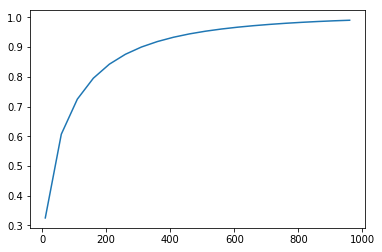

In [46]:
import matplotlib.pyplot as plt

plt.plot(x, explained_variance)

In [155]:
# df3.to_csv(path+'tabular.csv')
# df2.to_csv(path+'tabular_labels.csv')

In [129]:
svd_features = 200

svd = TruncatedSVD(n_components=svd_features, algorithm='arpack')
svd.fit(df3)

TruncatedSVD(algorithm='arpack', n_components=200, n_iter=5, random_state=None,
             tol=0.0)

In [130]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=16, random_state=0)
kmeans.fit(svd.transform(df3))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=16, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [131]:
df4 = pd.DataFrame(kmeans.transform(svd.transform(df3)))
df5 = pd.DataFrame(svd.transform(df3))

In [141]:
train = df4[:2500]
val = df4[2500:]

y_train = df2['label'][:2500].values
y_val = df2['label'][2500:].values

In [4]:
from sklearn.ensemble import *
#import lightgbm as lgb

#rf = GradientBoostingClassifier(n_estimators=100, max_depth=80,)
# params = {}
# params["objective"] = "multiclassova"
# params["num_class"] = 16
# #params["metric"] = "auc"
# params["n_estimators"] = 2000
# params["max_depth"] = 30
# #params["min_data_per_leaf"] = 50
# #params["min_child_weight"] = 0.0001
# params["num_leaves"] = 500
# params["learning_rate"] = 0.20
# params["lambda_l1"] = 1
# params["lambda_l2"] = 0
# params["feature_fraction"] = 0.7
# params["feature_fraction_seed"] = i
# params["bagging_seed"] = i
# params["device"] = "gpu"
#params["is_unbalance"] = True

In [149]:
rf.fit(train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=80,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [150]:
y_pred = rf.predict(val)

In [151]:
y_pred

array([11, 14,  2, 13, ...,  2,  6,  2, 12])

In [153]:
balanced_accuracy_score(y_val, y_pred)

0.05041810981179242

In [209]:
learner_text = text_classifier_learner(data_text, arch=AWD_LSTM, drop_mult=0.5, metrics=accuracy)
#learner_text.load_encoder('ft_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


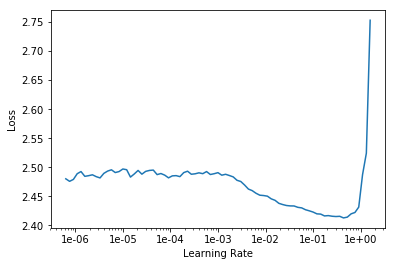

In [198]:
learner_text.lr_find()
learner_text.recorder.plot()

In [215]:
learner_text.fit_one_cycle(1,  max_lr=1e-06)

epoch,train_loss,valid_loss,accuracy,time
0,2.374938,2.298390,0.375862,00:01


In [206]:
learner_text.unfreeze()

In [205]:
learner_text.predict('sky ceiling')

(Category 2,
 tensor(2),
 tensor([0.0096, 0.0785, 0.4464, 0.0468, 0.0203, 0.0273, 0.0537, 0.0736, 0.0749,
         0.0300, 0.0186, 0.0459, 0.0421, 0.0116, 0.0082, 0.0127]))

In [3]:
df = pd.read_csv(path + 'train.csv')
df['fileName'] = df['fileName'].apply(lambda x: f"train/{x}.jpg")
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df = df.rename(columns={'fileName': 'name', 'tag': 'label'})
#df.to_csv(path+'labels.csv')

In [4]:
i = 3
idx = list(range(2730*i, 2730*i + 2730))
# idx = list(range(100))
# df = df[:500]
tfms = get_transforms(do_flip=True)
data = (ImageList.
              from_df(df, path=path).
              split_by_idx(idx).
              label_from_df(cols='label').
              transform(tfms ,size=350). #350
              databunch(bs=21) #21
              #.normalize(imagenet_stats)
           )

In [5]:
#arch = models.resnet50
#arch = models.resnet101
#arch = resnet.resnext101_32x8d
arch = models.densenet201

In [6]:
head = cnn_learner(data, arch, metrics=accuracy).model[1]

In [7]:
modules_all = []

for m in head:
    modules_all.append(m)

dropout = 0.25
l1=4096
l2=2048
l3=1024
l4=512
#resnet
# modules = modules_all[:-5]
# modules.append(nn.Linear(in_features=l1, out_features=l1, bias=True))
# modules.append(nn.ReLU(inplace=True))
# modules.append(nn.BatchNorm1d(l1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
# modules.append(nn.Dropout(p=dropout))
# modules.append(nn.Linear(in_features=l1, out_features=l2, bias=True))
# modules.append(nn.ReLU(inplace=True))
# modules.append(nn.BatchNorm1d(l2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
# modules.append(nn.Dropout(p=dropout))
# modules.append(nn.Linear(in_features=l2, out_features=l3, bias=True))
# modules.append(nn.ReLU(inplace=True))
# modules.append(nn.BatchNorm1d(l3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
# modules.append(nn.Dropout(p=dropout))
# # modules.append(nn.Linear(in_features=4096, out_features=4096, bias=True))
# # modules.append(nn.ReLU(inplace=True))
# # modules.append(nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
# # modules.append(nn.Dropout(p=dropout))
# modules.append(nn.Linear(in_features=l3, out_features=l4, bias=True))
# modules.append(nn.ReLU(inplace=True))
# modules.append(nn.BatchNorm1d(l4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
# modules.append(nn.Dropout(p=dropout))
# modules.append(nn.Linear(in_features=l4, out_features=16, bias=True))


#densenet201
modules = modules_all[:-5]
# modules.append(nn.Linear(in_features=3840, out_features=3840, bias=True))
# modules.append(nn.ReLU(inplace=True))
# modules.append(nn.BatchNorm1d(3840, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
# modules.append(nn.Dropout(p=dropout))
# modules.append(nn.Linear(in_features=3840, out_features=3840, bias=True))
# modules.append(nn.ReLU(inplace=True))
# modules.append(nn.BatchNorm1d(3840, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
# modules.append(nn.Dropout(p=dropout))
# modules.append(nn.Linear(in_features=3840, out_features=3840, bias=True))
# modules.append(nn.ReLU(inplace=True))
# modules.append(nn.BatchNorm1d(3840, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True))
# modules.append(nn.Dropout(p=dropout))
modules.append(modules_all[-5])
modules.append(modules_all[-4])
modules.append(modules_all[-3])
modules.append(modules_all[-2])
modules.append(modules_all[-1])

In [8]:
head2 = nn.Sequential(*modules)

In [9]:
learn = cnn_learner(data, arch, metrics=Balanced_Accuracy(), custom_head=head2).mixup().to_fp16()

In [10]:
# for g in learn.layer_groups[:-1]:
#     for l in g:
#         requires_grad(l, False)

In [11]:
learn.fit_one_cycle(25, max_lr=1e-03, callbacks=[SaveModelCallback(learn, every='improvement', monitor='balanced__accuracy',
                                                  name='model'),
                                                  ReduceLROnPlateauCallback(learn, patience=0, monitor='balanced__accuracy'),])

epoch,train_loss,valid_loss,balanced__accuracy,time
0,1.773139,0.942788,0.565828,07:11
1,1.434050,0.687613,0.660725,06:48
2,1.296106,0.601616,0.703557,06:50
3,1.181701,0.597975,0.722203,06:51
4,1.144451,0.593893,0.718541,06:54
5,1.130059,0.621145,0.690785,06:56
6,1.086534,0.625078,0.697509,06:57
7,1.064649,0.587339,0.705233,06:55
8,1.060314,0.584327,0.731947,06:55
9,1.043580,0.584547,0.720063,06:58


Better model found at epoch 0 with balanced__accuracy value: 0.5658279061317444.


/home/axel/anaconda3/envs/fastai-py37/lib/python3.7/site-packages/fastai/metrics.py:186: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 1 with balanced__accuracy value: 0.6607253551483154.
Better model found at epoch 2 with balanced__accuracy value: 0.7035567760467529.
Better model found at epoch 3 with balanced__accuracy value: 0.7222027778625488.
Epoch 4: reducing lr to 0.000152
Epoch 5: reducing lr to 0.00018166563145999496
Epoch 6: reducing lr to 0.00019790216967044535
Epoch 7: reducing lr to 0.00019959743100980633
Better model found at epoch 8 with balanced__accuracy value: 0.7319467067718506.
Epoch 9: reducing lr to 0.00019009692640269474
Epoch 10: reducing lr to 0.000180901775830697
Better model found at epoch 11 with balanced__accuracy value: 0.7414582371711731.
Better model found at epoch 12 with balanced__accuracy value: 0.744818389415741.
Epoch 13: reducing lr to 0.0001393027459553797
Better model found at epoch 14 with balanced__accuracy value: 0.7598569393157959.
Epoch 15: reducing lr to 0.00010448686508911935
Epoch 16: reducing lr to 8.657712711154081e-05
Epoch 17: reducing lr 

In [ ]:
learn.lr_find(start_lr=1e-12)
learn.recorder.plot(suggestion=True)

In [16]:
learn.fit_one_cycle(10, max_lr=1e-04, callbacks=[SaveModelCallback(learn, every='improvement', monitor='balanced__accuracy',
                                                  name='model-best-ft'),
                                                  ReduceLROnPlateauCallback(learn, patience=0, monitor='balanced__accuracy'),])

epoch,train_loss,valid_loss,balanced__accuracy,time
0,0.888362,0.472691,0.763696,06:29
1,0.876401,0.470474,0.771132,06:20
2,0.897004,0.472892,0.774956,06:19
3,0.880850,0.473444,0.760514,06:20
4,0.872140,0.469961,0.754456,06:19
5,0.873675,0.473871,0.754172,06:20
6,0.858656,0.472828,0.764750,06:29
7,0.865754,0.475006,0.760321,06:32
8,0.862812,0.473105,0.765416,06:17
9,0.825251,0.475687,0.761060,06:18


Better model found at epoch 0 with balanced__accuracy value: 0.7636964917182922.
Better model found at epoch 1 with balanced__accuracy value: 0.7711322903633118.
Better model found at epoch 2 with balanced__accuracy value: 0.7749563455581665.
Epoch 4: reducing lr to 1.6234913078995263e-05
Epoch 6: reducing lr to 7.774839561274216e-06
Epoch 8: reducing lr to 9.903873597305258e-07


In [12]:
#learn.save('model')
learn.load('model')

Learner(data=ImageDataBunch;

Train: LabelList (10920 items)
x: ImageList
Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350)
y: CategoryList
7,2,1,7,1
Path: /media/axel/ssd/despegar;

Valid: LabelList (2730 items)
x: ImageList
Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350),Image (3, 350, 350)
y: CategoryList
6,12,8,10,2
Path: /media/axel/ssd/despegar;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1):

In [11]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.37E-10
Min loss divided by 10: 2.00E-12


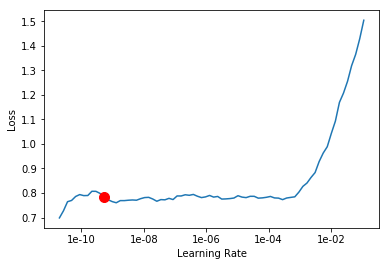

In [12]:
learn.lr_find(start_lr=1e-12)
learn.recorder.plot(suggestion=True)

In [13]:
learn.fit_one_cycle(4, max_lr=slice(1e-10,8e-10), callbacks=[SaveModelCallback(learn, every='improvement', monitor='balanced__accuracy',
                                                  name='model-best-ft'),
                                                  ReduceLROnPlateauCallback(learn, patience=0, monitor='balanced__accuracy'),])

epoch,train_loss,valid_loss,balanced__accuracy,time
0,0.801054,0.517928,0.768407,08:11
1,0.832439,0.518152,0.763496,07:50
2,0.804949,0.513764,0.764817,07:53
3,0.792003,0.517555,0.769014,07:58


/home/axel/anaconda3/envs/fastai-py37/lib/python3.7/site-packages/fastai/metrics.py:186: UserWarning: average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.
  warn("average=`binary` was selected for a non binary case. Value for average has now been set to `macro` instead.")


Better model found at epoch 0 with balanced__accuracy value: 0.7684066295623779.
Epoch 1: reducing lr to 1.298627615209338e-10
Epoch 2: reducing lr to 4.5280229026552214e-11
Better model found at epoch 3 with balanced__accuracy value: 0.7690137624740601.


In [16]:
learn.fit_one_cycle(8, max_lr=slice(1.28e-12,1.6e-06), callbacks=[SaveModelCallback(learn, every='improvement', monitor='balanced__accuracy',
                                                  name='model-best-ft'),
                                                  ReduceLROnPlateauCallback(learn, patience=0, monitor='balanced__accuracy'),])

epoch,train_loss,valid_loss,balanced__accuracy,time
0,0.773331,0.523126,0.758245,07:07
1,0.757843,0.521022,0.761495,07:04
2,0.770619,0.517672,0.759270,07:04
3,0.784655,0.518719,0.754376,07:07
4,0.797352,0.522450,0.759455,07:04
5,0.748020,0.521662,0.759398,07:03
6,0.752292,0.525132,0.758377,07:19
7,0.780713,0.521432,0.757512,07:15


Better model found at epoch 0 with balanced__accuracy value: 0.7582453489303589.
Better model found at epoch 1 with balanced__accuracy value: 0.7614949941635132.
Epoch 2: reducing lr to 3.1100001327875157e-07
Epoch 3: reducing lr to 2.5971818548330835e-07
Epoch 4: reducing lr to 1.7787635481756683e-07
Epoch 5: reducing lr to 9.055623150547334e-08
Epoch 6: reducing lr to 2.4518434313953484e-08
Epoch 7: reducing lr to 1.28e-12


In [28]:
#learn.save('model-4cycles-ft')
#learn.load('model-4cycles-ft')

In [17]:
#learn.fit_one_cycle(4, max_lr=slice(1e-11,1e-4))

In [13]:
learn.fit(20,  lr=1e-03, callbacks=[ReduceLROnPlateauCallback(learn, patience=0, monitor='balanced_accuracy'),
                                                  SaveModelCallback(learn, every='improvement', monitor='balanced_accuracy',
                                                  name='model-best')])

epoch,train_loss,valid_loss,accuracy,time
0,1.334878,0.660359,0.789377,07:06
1,1.282111,0.655663,0.787546,07:05
2,1.110116,0.542166,0.823810,07:24
3,1.080495,0.530712,0.833333,07:18
4,1.064466,0.528395,0.831136,07:32
5,1.007220,0.496799,0.839194,07:18
6,1.006130,0.492692,0.840659,07:45
7,0.984901,0.491454,0.841758,07:35
8,0.973907,0.487298,0.847253,07:26
9,0.961742,0.491346,0.842857,07:36


Better model found at epoch 0 with accuracy value: 0.7893772721290588.
Epoch 1: reducing lr to 0.0002
Better model found at epoch 2 with accuracy value: 0.8238095045089722.
Better model found at epoch 3 with accuracy value: 0.8333333134651184.
Epoch 4: reducing lr to 4e-05
Better model found at epoch 5 with accuracy value: 0.839194118976593.
Better model found at epoch 6 with accuracy value: 0.8406593203544617.
Better model found at epoch 7 with accuracy value: 0.8417582511901855.
Better model found at epoch 8 with accuracy value: 0.8472527265548706.
Epoch 9: reducing lr to 8.000000000000001e-06


KeyboardInterrupt: 

In [ ]:
#0.8593 best

In [15]:
#learn.fit_one_cycle(2,  max_lr=1e-03)

In [12]:
#learn.save('model-resnext-chico')
learn.load('resnet50-1')

Learner(data=ImageDataBunch;

Train: LabelList (10920 items)
x: ImageList
Image (3, 430, 430),Image (3, 430, 430),Image (3, 430, 430),Image (3, 430, 430),Image (3, 430, 430)
y: CategoryList
2,4,12,4,1
Path: /media/axel/ssd/despegar;

Valid: LabelList (2730 items)
x: ImageList
Image (3, 430, 430),Image (3, 430, 430),Image (3, 430, 430),Image (3, 430, 430),Image (3, 430, 430)
y: CategoryList
7,2,1,7,1
Path: /media/axel/ssd/despegar;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2)

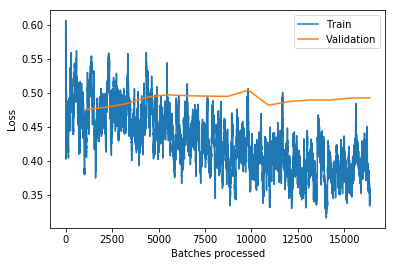

In [15]:
learn.recorder.plot_losses()

In [ ]:
# learn.lr_find()
# learn.recorder.plot()

In [21]:
learn.fit_one_cycle(1,  max_lr=1e-04)

epoch,train_loss,valid_loss,accuracy,time
0,0.592158,0.503714,0.834432,20:40


In [24]:
learn.layer_groups = split_model_idx(learn.model, [235])

In [12]:
learn.freeze_to(1)
#learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


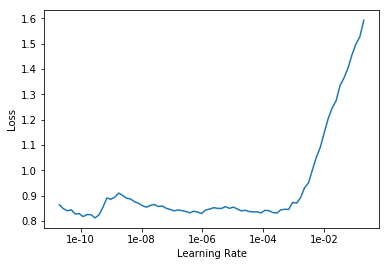

In [12]:
learn.lr_find(start_lr=1e-12)
learn.recorder.plot()

In [13]:
#del learn.model
#del learn
#gc.collect()
#torch.cuda.empty_cache()

In [12]:
preds = learn.get_preds(DatasetType.Valid)

y_pred = []

for i in range(len(preds[0])):
    y_pred.append(np.argmax(preds[0][i].numpy()))

In [13]:
balanced_accuracy_score(data.valid_ds.y.items, y_pred)

#0.740 val - 0.718 test (resnext-101, 0.12% val)
#0.761 val - 0.735 test (resnext-101, 0.12% val)
#0.775 val - 0.748 test (resnext-101, 0.12% val)
#0.795 val - 0.75  test (resnet50, 0.1% val)
#0.789 val - 0.759 test (resnet152)
#0.796 val - 0.770 test (resnet50, head tam 4)
#0.773 val - 0.750 test (resnet50, primeros 20% val)
#0.769 val - 0.767 test (densenet201, primeros 20% val)

0.7768476079743504

In [44]:
#learn.save('model-resnext-1')

In [13]:
data.add_test(ImageList.from_folder(path+'test'))
data.test_ds.x.items.sort()

In [14]:
#preds,  = learn.TTA(ds_type=DatasetType.Test)
preds,y = learn.get_preds(DatasetType.Test)
all_preds = list(learn.tta_only(ds_type=DatasetType.Test, num_pred=10))

In [15]:
avg_preds = np.mean(torch.stack(all_preds).numpy(), axis=0)

In [16]:
preds = avg_preds

y_pred = []

for i in range(len(preds)):
    y_pred.append(np.argmax(preds[i]))
    
df_sub = pd.read_csv('ejemploRespuesta.csv')

for i in range(len(data.test_ds)):
    idx = int(data.test_ds.x.items[i].stem)
    df_sub.loc[df_sub.id == idx, ['target']] = y_pred[i]
    
df_sub.to_csv('../../sub.csv', index=False, header=None)

In [42]:
# #preds = learn.get_preds(DatasetType.Test)

# y_pred = []

# for i in range(len(preds[0])):
#     y_pred.append(np.argmax(preds[0][i].numpy()))
    
# df_sub = pd.read_csv('ejemploRespuesta.csv')

# for i in range(len(data.test_ds)):
#     idx = int(data.test_ds.x.items[i].stem)
#     df_sub.loc[df_sub.id == idx, ['target']] = y_pred[i]
    
# df_sub.to_csv('../../sub.csv', index=False, header=None)

In [19]:
df1 = pd.read_csv(path+'sub-model1.csv', header=None)
df2 = pd.read_csv(path+'sub-model2.csv', header=None)
df3 = pd.read_csv(path+'sub-model3.csv', header=None)
df4 = pd.read_csv(path+'sub-model4.csv', header=None)
df5 = pd.read_csv(path+'sub-model5.csv', header=None)
df2.drop([0], axis=1, inplace=True)
df3.drop([0], axis=1, inplace=True)
df4.drop([0], axis=1, inplace=True)
df5.drop([0], axis=1, inplace=True)
df1.rename(columns = {1:'target_1'}, inplace = True)
df2.rename(columns = {1:'target_2'}, inplace = True)
df3.rename(columns = {1:'target_3'}, inplace = True)
df4.rename(columns = {1:'target_4'}, inplace = True)
df5.rename(columns = {1:'target_5'}, inplace = True)

In [20]:
df_sub = pd.concat([df1, df2, df3, df4, df5], axis=1)

In [21]:
df_sub['target'] = df_sub[['target_1', 'target_2', 'target_3', 'target_4', 'target_5']].max(axis=1)

In [22]:
df_sub[[0, 'target']].to_csv('../../sub.csv', index=False, header=None)

In [227]:
p = learn.predict(data.test_ds[0][0])

In [223]:
p[1].numpy()

array(1)

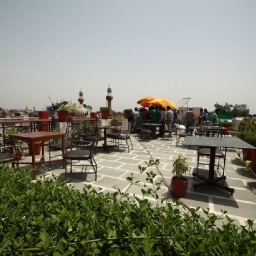

In [288]:
data.test_ds[4][0]

In [287]:
data.test_ds.x.items[3]

PosixPath('/media/axel/ssd/despegar/test/100.jpg')

1

1